## Download Street View for six cities

### Visualize road Network

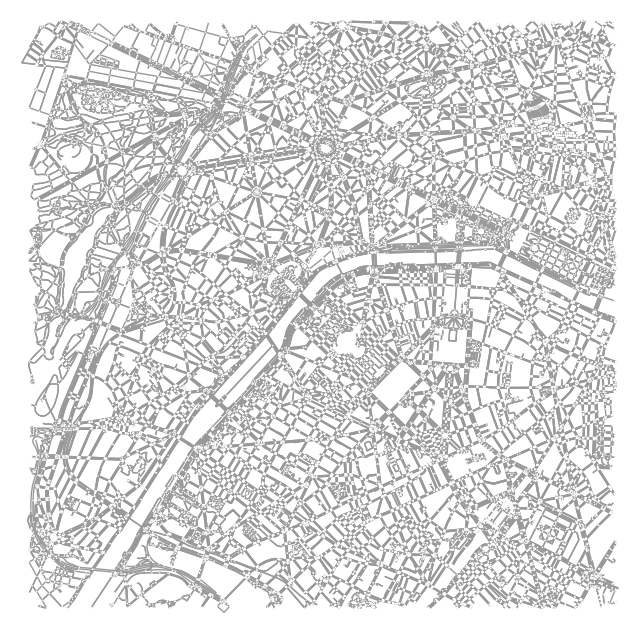

Visualized road network for Eiffel Tower, Paris


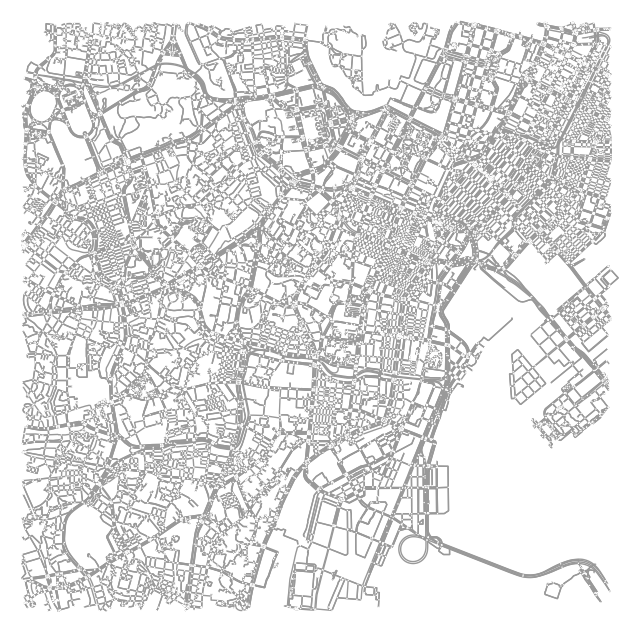

Visualized road network for Tokyo Tower, Tokyo


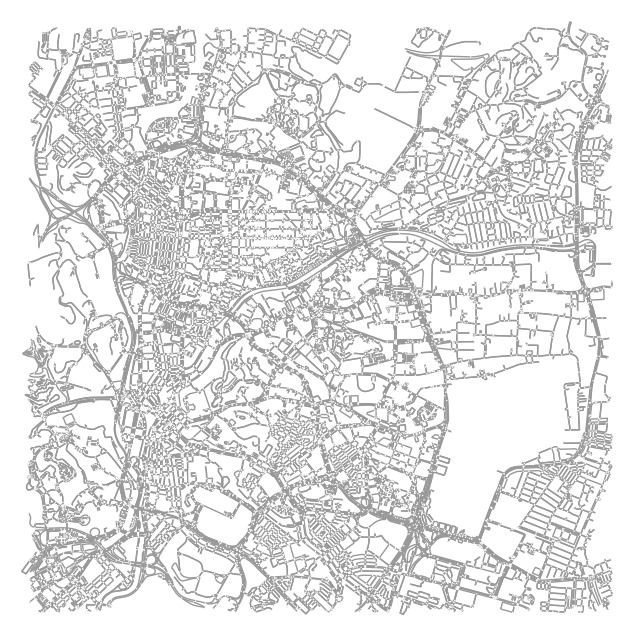

Visualized road network for Petronas Towers, Kuala Lumpur


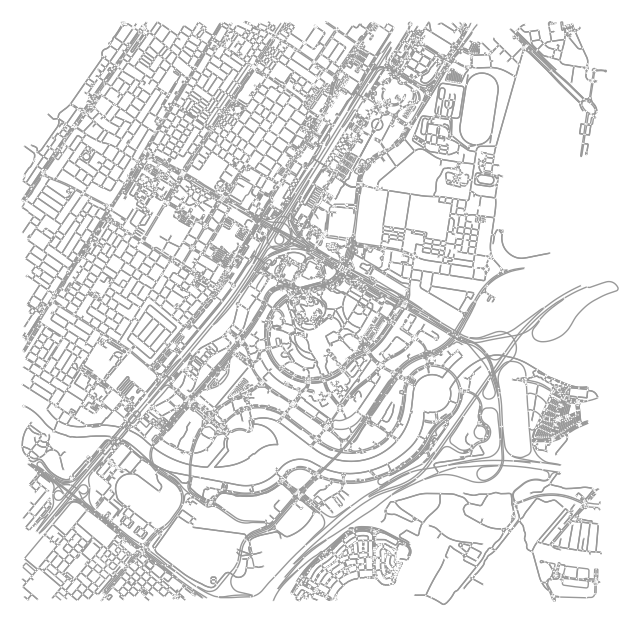

Visualized road network for Burj Khalifa, Dubai


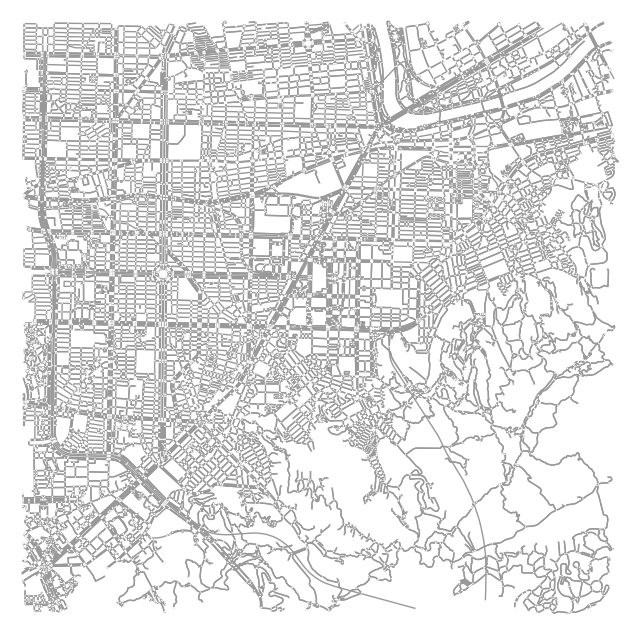

Visualized road network for Taipei 101, Taipei


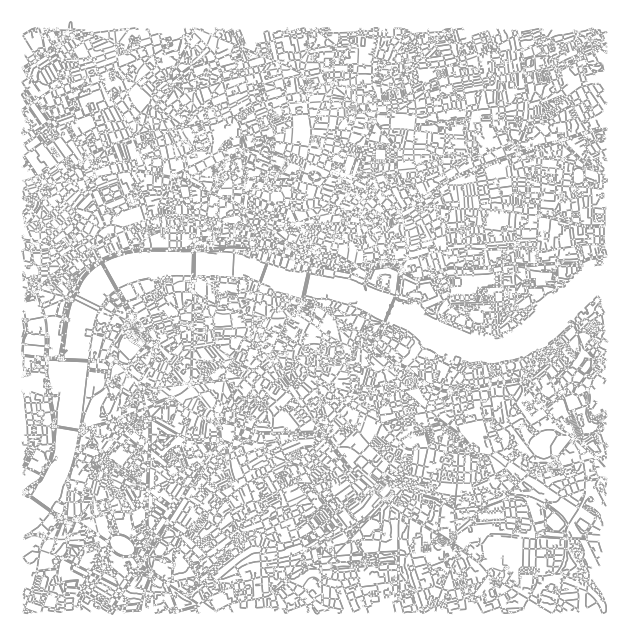

Visualized road network for The Shard, London


In [26]:
import osmnx as ox

# Define landmark coordinates
landmarks = {
    "Eiffel Tower, Paris": (48.8584, 2.2945),        # Eiffel Tower
    "Tokyo Tower, Tokyo": (35.6586, 139.7454),       # Tokyo Tower
    "Petronas Towers, Kuala Lumpur": (3.1579, 101.7113), # Petronas Towers
    "Burj Khalifa, Dubai": (25.1972, 55.2744),       # Burj Khalifa
    "Taipei 101, Taipei": (25.0339, 121.5645),       # Taipei 101
    "The Shard, London": (51.5045, -0.0865)          # The Shard, London
}

# Iterate through each landmark
for name in landmarks.keys():
    # Construct filename
    filename = f"data/global_osm/{name.replace(', ', '_').replace(' ', '_')}_road_network.graphml"
    
    try:
        # Read saved GraphML file
        graph = ox.load_graphml(filename)
        
        # Only visualize, don't save image
        ox.plot_graph(graph, node_size=1, edge_linewidth=1, bgcolor='w')
        print(f"Visualized road network for {name}")
    except FileNotFoundError:
        print(f"GraphML file not found for {name}")


### Extract Sampling points based on the road network

In [27]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from scipy.spatial import cKDTree

# Define UTM zone CRS for each city
crs_dict = {
    "Paris": "EPSG:32631",          # UTM Zone 31N
    "Tokyo": "EPSG:32654",          # UTM Zone 54N
    "Kuala Lumpur": "EPSG:32647",   # UTM Zone 47N
    "Dubai": "EPSG:32640",          # UTM Zone 40N
    "Taipei": "EPSG:32651",         # UTM Zone 51N
    "London": "EPSG:32630"          # UTM Zone 30N (for The Shard in London)
}

# Function to sample points along each line segment
def sample_points_along_line(geom, distance):
    if geom.length < distance:
        return [geom.interpolate(geom.length / 2)]
    num_vertices = int(geom.length // distance) + 1
    points = [geom.interpolate(float(n) / num_vertices, normalized=True) for n in range(num_vertices)]
    return points

# Function to process road network for each city
def process_city_roads(city_name, graph, distance=50):
    # Step 1: Convert OSMNx graph to GeoDataFrame
    gdf = ox.graph_to_gdfs(graph, nodes=False, edges=True)

    # Step 2: Reproject to the appropriate UTM CRS for the city
    utm_crs = crs_dict.get(city_name)
    if not utm_crs:
        raise ValueError(f"CRS for {city_name} not found.")
    gdf = gdf.to_crs(utm_crs)

    # Step 3: Apply the sampling function to each road segment and collect points
    sampled_points = []
    for _, row in gdf.iterrows():
        line = row.geometry
        
        # Check if the geometry is a LineString
        if isinstance(line, LineString):
            sampled_points.extend(sample_points_along_line(line, distance))  # Sampling every 50 meters
        
        # Check if the geometry is a MultiLineString
        elif isinstance(line, MultiLineString):
            for single_line in line.geoms:  # Use the .geoms attribute to iterate over LineStrings
                sampled_points.extend(sample_points_along_line(single_line, distance))  # Sampling every 50 meters

    # Step 4: Create a GeoDataFrame from the sampled points
    gdf_points = gpd.GeoDataFrame(geometry=sampled_points, crs=utm_crs)
    return gdf_points

# Function to filter points by minimum distance using cKDTree
def filter_points_by_distance(points_gdf, min_distance=10):
    coords = [(geom.x, geom.y) for geom in points_gdf.geometry]
    tree = cKDTree(coords)
    
    to_keep = set()
    for i in range(len(coords)):
        if i in to_keep:
            continue
        neighbors = tree.query_ball_point(coords[i], min_distance)
        to_keep.add(i)
        for neighbor in neighbors:
            if neighbor != i:
                to_keep.discard(neighbor)
                
    filtered_gdf = points_gdf.iloc[list(to_keep)]
    return filtered_gdf

# Main processing loop for each city
landmarks = {
    "Eiffel Tower, Paris": (48.8584, 2.2945),        # Eiffel Tower
    "Tokyo Tower, Tokyo": (35.6586, 139.7454),       # Tokyo Tower
    "Petronas Towers, Kuala Lumpur": (3.1579, 101.7113), # Petronas Towers
    "Burj Khalifa, Dubai": (25.1972, 55.2744),       # Burj Khalifa
    "Taipei 101, Taipei": (25.0339, 121.5645),       # Taipei 101
    "The Shard, London": (51.5045, -0.0865)          # The Shard, London
}

# Sample at 50m intervals, but may get points closer than 50m, so need secondary filtering
# Secondary filtering distance is 20m

radius = 3000  # 5 km radius
distance_interval = 50  # Sampling every 50 meters
min_filter_distance = 20  # Minimum distance between sampled points (in meters)

for name, coords in landmarks.items():
    # Step 1: Load the OSM road network
    filename = f"data/global_osm/{name.replace(', ', '_').replace(' ', '_')}_road_network.graphml"
    graph = ox.load_graphml(filename)
    
    # Step 2: Process city roads to sample points
    city_name = name.split(', ')[1]  # Extract city name
    gdf_sampled_points = process_city_roads(city_name, graph, distance=distance_interval)
    
    # Step 3: Filter points by minimum distance
    gdf_sampled_points = filter_points_by_distance(gdf_sampled_points, min_distance=min_filter_distance)
    
    # Step 4: Reproject the points back to WGS84 (EPSG:4326)
    gdf_sampled_points = gdf_sampled_points.to_crs("EPSG:4326")

    # Step 5: (Optional) Save to CSV
    gdf_sampled_points["lon"] = gdf_sampled_points.geometry.x
    gdf_sampled_points["lat"] = gdf_sampled_points.geometry.y
    gdf_sampled_points[["lon", "lat"]].to_csv(f"data/global_sampling_points/{city_name}_sampled_points.csv", index=False)

    print(f"Processed and saved sampled points for {name}")


Processed and saved sampled points for Eiffel Tower, Paris
Processed and saved sampled points for Tokyo Tower, Tokyo
Processed and saved sampled points for Petronas Towers, Kuala Lumpur
Processed and saved sampled points for Burj Khalifa, Dubai
Processed and saved sampled points for Taipei 101, Taipei
Processed and saved sampled points for The Shard, London


### Download SVI according to location

In [5]:
import logging
import pandas as pd
from streetlevel import streetview
from joblib import Parallel, delayed
from tqdm import tqdm  # Importing tqdm for progress bar
import os
import json

# Configure logging
logging.basicConfig(filename='error_log.log', level=logging.ERROR)

# Define landmarks for creating subfolders
landmarks = {
    "Eiffel Tower, Paris": (48.8584, 2.2945),
    #"Tokyo Tower, Tokyo": (35.6586, 139.7454),
    #"Petronas Towers, Kuala Lumpur": (3.1579, 101.7113),
    #"Burj Khalifa, Dubai": (25.1972, 55.2744),
    #"Taipei 101, Taipei": (25.0339, 121.5645),
    #"The Shard, London": (51.5045, -0.0865)
}

# Base directory for all images and metadata
base_dir = 'data/global_svi_images'
csv_output_dir = 'data/global_pano_metadata'
progress_file = 'data/progress_tracker.json'  # Track the last completed chunk for each landmark

# Create necessary directories if they do not exist
os.makedirs(base_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)

# Function to load progress from a JSON file
def load_progress():
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            return json.load(f)
    return {}

# Function to save progress to a JSON file
def save_progress(progress):
    with open(progress_file, 'w') as f:
        json.dump(progress, f, indent=4)

# Function to process a single point and update progress after each panorama is found
def process_sampling_point(landmark_name, city_name, sampling_point, index, session, progress, chunk_idx):
    # Create subfolder for every 1,000 images
    folder_idx = index // 1000
    image_subfolder = os.path.join(base_dir, landmark_name.replace(', ', '_').replace(' ', '_'), str(folder_idx))
    os.makedirs(image_subfolder, exist_ok=True)

    try:
        # Find panorama by coordinates (lon, lat)
        pano = streetview.find_panorama(sampling_point[1], sampling_point[0])
        if pano is None:
            return None
        
        # Save pano_id, location (lat/lon), and original sampling point
        pano_metadata = {
            'pano_id': pano.id,
            'pano_lat': pano.lat,
            'pano_lon': pano.lon,
            'heading': pano.heading,
            'roll': pano.roll,
            'pitch': pano.pitch,
            'sampling_lat': sampling_point[1],
            'sampling_lon': sampling_point[0]
        }

        # Download the panorama image
        pano_image_path = os.path.join(image_subfolder, f"{pano.id}.jpg")
        if not os.path.exists(pano_image_path):  # Avoid redownloading existing images
            streetview.download_panorama(pano, pano_image_path, zoom=4)

        # **Update progress for each find**
        progress[landmark_name] = chunk_idx
        save_progress(progress)

        return pano_metadata

    except Exception as e:  # Catch any unexpected errors
        logging.error(f"Unexpected error with panorama at point {sampling_point}: {e}")
        return None

# Function to chunk the sampling list
def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Function to process each landmark
def process_landmark(landmark_name, progress):
    city_name = landmark_name.split(', ')[1]  # Extract city name
    landmark_subfolder = os.path.join(base_dir, landmark_name.replace(', ', '_').replace(' ', '_'))
    os.makedirs(landmark_subfolder, exist_ok=True)

    # Load the CSV file containing sampling points for the current city
    sampled_points = pd.read_csv(f"data/global_sampling_points/{city_name}_sampled_points.csv")
    sampling_point_list = list(zip(sampled_points['lon'], sampled_points['lat']))  # Create (lon, lat) tuples

    # Check if there is an existing metadata file to continue processing
    csv_filename = os.path.join(csv_output_dir, f"{city_name}_pano_metadata.csv")
    if os.path.exists(csv_filename):
        processed_df = pd.read_csv(csv_filename)
        processed_ids = set(processed_df['pano_id'].values)
        start_index = len(processed_ids)
        pano_data = processed_df.to_dict(orient='records')
    else:
        start_index = 0
        pano_data = []

    # Resume progress from last saved batch
    last_chunk = progress.get(landmark_name, 0)

    # Chunk the sampling points and process them in parallel
    chunk_size = 1000
    for chunk_idx, chunk in enumerate(chunk_list(sampling_point_list[start_index:], chunk_size), start=start_index // chunk_size):
        if chunk_idx < last_chunk:
            print(f"Skipping chunk {chunk_idx + 1} for {landmark_name} (already processed)")
            continue

        print(f"Processing chunk {chunk_idx + 1} for {landmark_name}...")

        # Initialize tqdm progress bar for the current chunk
        with tqdm(total=len(chunk), desc=f"Processing {landmark_name}, chunk {chunk_idx + 1}", unit='point') as pbar:

            # Use joblib to parallelize the processing of each sampling point
            results = Parallel(n_jobs=2)(
                delayed(process_sampling_point)(landmark_name, city_name, sampling_point, idx, None, progress, chunk_idx)
                for idx, sampling_point in enumerate(chunk, start=start_index + chunk_idx * chunk_size)
            )

            # Update the progress bar
            for result in results:
                pbar.update(1)

            # Filter out None values and append results
            pano_data.extend([r for r in results if r is not None])

        # **Save panorama metadata after each chunk with unique name (landmark + chunk)**
        chunk_csv_filename = os.path.join(csv_output_dir, f"{city_name}_pano_metadata_{chunk_idx}.csv")
        pano_df = pd.DataFrame(pano_data)
        pano_df.to_csv(chunk_csv_filename, index=False)
        print(f"Saved panorama metadata for {landmark_name} (chunk {chunk_idx + 1}) to {chunk_csv_filename}")

        # Update the progress tracker after each chunk
        progress[landmark_name] = chunk_idx + 1
        save_progress(progress)

In [6]:

progress = load_progress()

    # Process each landmark one by one
for landmark_name in landmarks.keys():
    process_landmark(landmark_name, progress)

Processing chunk 1 for The Shard, London...


Processing The Shard, London, chunk 1:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:root:Unexpected error with panorama at point (-0.1228490000000007, 51.51512869999999): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7d8df4e455d0>
Processing The Shard, London, chunk 1: 100%|██████████| 1000/1000 [16:09<00:00,  1.03point/s]  


Saved panorama metadata for The Shard, London (chunk 1) to data/global_pano_metadata/London_pano_metadata_0.csv
Processing chunk 2 for The Shard, London...


Processing The Shard, London, chunk 2: 100%|██████████| 1000/1000 [13:45<00:00,  1.21point/s]  


Saved panorama metadata for The Shard, London (chunk 2) to data/global_pano_metadata/London_pano_metadata_1.csv
Processing chunk 3 for The Shard, London...


Processing The Shard, London, chunk 3: 100%|██████████| 1000/1000 [14:00<00:00,  1.19point/s]  


Saved panorama metadata for The Shard, London (chunk 3) to data/global_pano_metadata/London_pano_metadata_2.csv
Processing chunk 4 for The Shard, London...


Processing The Shard, London, chunk 4: 100%|██████████| 1000/1000 [13:29<00:00,  1.24point/s]  


Saved panorama metadata for The Shard, London (chunk 4) to data/global_pano_metadata/London_pano_metadata_3.csv
Processing chunk 5 for The Shard, London...


Processing The Shard, London, chunk 5: 100%|██████████| 1000/1000 [13:33<00:00,  1.23point/s]  


Saved panorama metadata for The Shard, London (chunk 5) to data/global_pano_metadata/London_pano_metadata_4.csv
Processing chunk 6 for The Shard, London...


Processing The Shard, London, chunk 6: 100%|██████████| 1000/1000 [13:49<00:00,  1.21point/s]  


Saved panorama metadata for The Shard, London (chunk 6) to data/global_pano_metadata/London_pano_metadata_5.csv
Processing chunk 7 for The Shard, London...


Processing The Shard, London, chunk 7: 100%|██████████| 1000/1000 [15:57<00:00,  1.04point/s]  


Saved panorama metadata for The Shard, London (chunk 7) to data/global_pano_metadata/London_pano_metadata_6.csv
Processing chunk 8 for The Shard, London...


Processing The Shard, London, chunk 8:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3de925b90>
Processing The Shard, London, chunk 8: 100%|██████████| 1000/1000 [13:02<00:00,  1.28point/s]  


Saved panorama metadata for The Shard, London (chunk 8) to data/global_pano_metadata/London_pano_metadata_7.csv
Processing chunk 9 for The Shard, London...


Processing The Shard, London, chunk 9: 100%|██████████| 1000/1000 [13:38<00:00,  1.22point/s]  


Saved panorama metadata for The Shard, London (chunk 9) to data/global_pano_metadata/London_pano_metadata_8.csv
Processing chunk 10 for The Shard, London...


Processing The Shard, London, chunk 10:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:root:Unexpected error with panorama at point (-0.1005429105206217, 51.5116071053875): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3eed86890>
ERROR:root:Unexpected error with panorama at point (-0.0829178999999998, 51.503441): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3dff71050>
ERROR:root:Unexpected error with panorama at point (-0.0828146275829973, 51.50313180239806): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7d8e1272d890>
Processing The Shard, London, chunk 10: 100%|██████████| 1000/1000 [19:28<00:00,  1.17s/point]   


Saved panorama metadata for The Shard, London (chunk 10) to data/global_pano_metadata/London_pano_metadata_9.csv
Processing chunk 11 for The Shard, London...


Processing The Shard, London, chunk 11: 100%|██████████| 1000/1000 [13:14<00:00,  1.26point/s]  


Saved panorama metadata for The Shard, London (chunk 11) to data/global_pano_metadata/London_pano_metadata_10.csv
Processing chunk 12 for The Shard, London...


Processing The Shard, London, chunk 12: 100%|██████████| 1000/1000 [13:29<00:00,  1.23point/s]  


Saved panorama metadata for The Shard, London (chunk 12) to data/global_pano_metadata/London_pano_metadata_11.csv
Processing chunk 13 for The Shard, London...


Processing The Shard, London, chunk 13:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:root:Unexpected error with panorama at point (-0.0762770201621374, 51.49994301699827): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3de6ae590>
Processing The Shard, London, chunk 13: 100%|██████████| 1000/1000 [15:39<00:00,  1.06point/s]  


Saved panorama metadata for The Shard, London (chunk 13) to data/global_pano_metadata/London_pano_metadata_12.csv
Processing chunk 14 for The Shard, London...


Processing The Shard, London, chunk 14:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:root:Unexpected error with panorama at point (-0.0768146023684711, 51.50318090034457): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3e039cf50>
Processing The Shard, London, chunk 14: 100%|██████████| 1000/1000 [15:42<00:00,  1.06point/s]  


Saved panorama metadata for The Shard, London (chunk 14) to data/global_pano_metadata/London_pano_metadata_13.csv
Processing chunk 15 for The Shard, London...


Processing The Shard, London, chunk 15:   0%|          | 0/1000 [00:00<?, ?point/s]ERROR:root:Unexpected error with panorama at point (-0.1152012999999991, 51.499013): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3f692fad0>
ERROR:root:Unexpected error with panorama at point (-0.098774353179533, 51.51127559841598): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7bb3dea61d90>
ERROR:root:Unexpected error with panorama at point (-0.1002004021281615, 51.51126114013376): 
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7d8e0bb0a7d0>
Processing The Shard, London, chunk 15: 100%|██████████| 1000/1000 [20:16<00:00,  1.22s/point]   


Saved panorama metadata for The Shard, London (chunk 15) to data/global_pano_metadata/London_pano_metadata_14.csv
Processing chunk 16 for The Shard, London...


Processing The Shard, London, chunk 16: 100%|██████████| 1000/1000 [13:51<00:00,  1.20point/s]  


Saved panorama metadata for The Shard, London (chunk 16) to data/global_pano_metadata/London_pano_metadata_15.csv
Processing chunk 17 for The Shard, London...


Processing The Shard, London, chunk 17: 100%|██████████| 1000/1000 [13:29<00:00,  1.23point/s]  


Saved panorama metadata for The Shard, London (chunk 17) to data/global_pano_metadata/London_pano_metadata_16.csv
Processing chunk 18 for The Shard, London...


Processing The Shard, London, chunk 18: 100%|██████████| 1000/1000 [13:23<00:00,  1.24point/s]  


Saved panorama metadata for The Shard, London (chunk 18) to data/global_pano_metadata/London_pano_metadata_17.csv
Processing chunk 19 for The Shard, London...


Processing The Shard, London, chunk 19: 100%|██████████| 762/762 [14:51<00:00,  1.17s/point]   

Saved panorama metadata for The Shard, London (chunk 19) to data/global_pano_metadata/London_pano_metadata_18.csv


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7d8df656b5d0>
